# Primordial non-Gaussianity examples

In this notebook we will show how to perform PNG fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np
import tqdm
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 201)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
pk_prim = cosmo.get_primordial(mode='scalar').pk_interpolator()(k)
pphi_prim = 9 / 25 * 2 * np.pi**2 / k**3 * pk_prim / cosmo.h**3
alpha = 1. / (pk / pphi_prim)**0.5

fnl = 100.
# PNG response of dark matter halos in spherical collapse
b1 = 2.
bphi = 2. * 1.686 * (b1 - 1.)
b = b1 + bphi * fnl * alpha
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = 1 / 1e-4
volume = 1e9

ells = (0, 2)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in tqdm.tqdm(range(1001)):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

100%|██████████| 1001/1001 [00:28<00:00, 34.82it/s]


## PNG likelihood

In [2]:
from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, PNGTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = FixedPowerSpectrumTemplate(z=z, fiducial='DESI')
# fnl_loc is degenerate with PNG bias bphi. Parameterization is controlled by "mode".
# - "b-p": bphi = 2 * 1.686 * (b1 - p), p as a parameter
# - "bphi": bphi as a parameter
# - "bfnl_loc": bfnl_loc = bphi * fnl_loc as a parameter'
# Here we choose b-p parameterization
theory = PNGTracerPowerSpectrumMultipoles(template=template, mode='b-p')
theory.init.params['p'].update(fixed=True)  # not fixing p biases fnl_loc posterior
# In our mock data sigmas = 0, so just fix it to 0
#theory.init.params['sigmas'].value = 0.
#theory.init.params['sigmas'].fixed = True
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     #klim={0: [0.005, 0.2]},
                                                     klim={0: [0.005, 0.2, 0.005], 2: [0.005, 0.2, 0.005]}, # fit monopole and quadrupole, between 0.005 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()
likelihood()  # just to initialize

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:675: UserWarning: Unable to match step 0.005 with edges [0.     0.0015 0.003  ... 0.297  0.2985 0.3   ]
  warnings.warn('Unable to match step {} with edges {}'.format(xlim[2], self.edges[iaxis]))


[000003.53] [0/1] 05-05 14:05  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations.
[000003.53] [0/1] 05-05 14:05  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9129.
[000003.53] [0/1] 05-05 14:05  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations, varying 4 parameters.
[000003.54] [0/1] 05-05 14:05  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0841.


Array(-39.20899848, dtype=float64)

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=5)

[000004.22] [0/1] 05-05 14:05  MinuitProfiler            INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].


[000004.66] [0/1] 05-05 14:05  MinuitProfiler            INFO     Successfully jit input likelihood.


In [4]:
print(profiles.to_stats(tablefmt='pretty'))

+-------------------------------------+--------+---------+-------+
| chi2 / (86 - 4) = 65.94 / 82 = 0.80 | varied | bestfit | error |
+-------------------------------------+--------+---------+-------+
|               fnl_loc               |  True  |   22    |  53   |
|                 b1                  |  True  |  2.027  | 0.025 |
|                 sn0                 |  True  |  0.001  | 0.012 |
|               sigmas                |  True  |   0.0   |  9.2  |
+-------------------------------------+--------+---------+-------+


In [ ]:
observable.plot(scaling='loglog', interactive={'params': profiles.bestfit.choice(input=True)})

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:675: UserWarning: Unable to match step 0.005 with edges [0.     0.0015 0.003  ... 0.297  0.2985 0.3   ]
  warnings.warn('Unable to match step {} with edges {}'.format(xlim[2], self.edges[iaxis]))


interactive(children=(FloatSlider(value=21.94259477793118, description='$f_{\\mathrm{NL}}^{\\mathrm{loc}}$ : '…

## PNG likelihood with Galaxy-Velocity Power Spectrum:

In [6]:
ells = (1, 3)
poles = []
# DO not add imaginary since it is removed in theory -> No problem.
poles.append((b + 3/5 * f) * f * 100 / (1+z) / k * pk)
poles.append( 2/5 * f**2 * 100 / (1+z) / k * pk)
poles = np.array(poles)


from pypower import PowerSpectrumStatistics
mean_gv = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=0, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks_tmp = []
for i in tqdm.tqdm(range(1001)):
    tmp = mean_gv.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean_gv.power_nonorm.ravel(), cov)
    mocks_tmp.append(tmp)
data_gv, mocks_gv = mocks_tmp[0], mocks_tmp[1:]

100%|██████████| 1001/1001 [00:28<00:00, 34.78it/s]


In [7]:
from desilike.theories.galaxy_clustering import PNGTracerVelocityPowerSpectrumMultipoles

theory_gv = PNGTracerVelocityPowerSpectrumMultipoles(template=template, mode='b-p')
theory_gv.init.params['fnl_loc'].update(fixed=False, value=0)  # not fixing p biases fnl_loc posterior
theory_gv.init.params['p'].update(fixed=True)  # not fixing p biases fnl_loc posterior
theory_gv.init.params['b1'].update(fixed=False, value=2)  # Amplitude in P^gv_1 as well as in P^gg_0/2
theory_gv.init.params['bv'].update(fixed=False, value=1)  # completely degenerated with b1 on P^gv_1 but fix the amplitude of P^gv_3
# Nuisance parameter to account for FoG:
theory_gv.init.params['sigmas'].update(fixed=False, value=0)
theory_gv.init.params['sigmau'].update(fixed=False, value=0)

observable_gv = TracerPowerSpectrumMultipolesObservable(data=data_gv, covariance=mocks_gv,
                                                        klim={1: [0.005, 0.2, 0.005], 3: [0.005, 0.2, 0.005]},
                                                        theory=theory_gv)
likelihood_gv = ObservablesGaussianLikelihood(observables=[observable_gv])

likelihood_gv()  # just to initialize

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:675: UserWarning: Unable to match step 0.005 with edges [0.     0.0015 0.003  ... 0.297  0.2985 0.3   ]
  warnings.warn('Unable to match step {} with edges {}'.format(xlim[2], self.edges[iaxis]))


[000045.02] [0/1] 05-05 14:06  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations.
[000045.02] [0/1] 05-05 14:06  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9129.
[000045.02] [0/1] 05-05 14:06  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations, varying 5 parameters.
[000045.02] [0/1] 05-05 14:06  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0818.


Array(-55.0281319, dtype=float64)

[000045.58] [0/1] 05-05 14:06  MinuitProfiler            INFO     Varied parameters: ['fnl_loc', 'b1', 'bv', 'sigmas', 'sigmau'].
[000045.86] [0/1] 05-05 14:06  MinuitProfiler            INFO     Could *not* jit input likelihood.
[000045.86] [0/1] 05-05 14:06  MinuitProfiler            INFO     Could *not* vmap input likelihood. Set logging level to debug (setup_logging("debug")) to get full stack trace.
+-------------------------------------+--------+---------+-------+
| chi2 / (86 - 5) = 67.38 / 81 = 0.83 | varied | bestfit | error |
+-------------------------------------+--------+---------+-------+
|               fnl_loc               |  True  |   95    |  48   |
|                 b1                  |  True  |  2.103  | 0.033 |
|                 bv                  |  True  |  0.963  | 0.011 |
|               sigmas                |  True  |   0.0   |  7.9  |
|               sigmau                |  True  |   0.    |  50.  |
+-------------------------------------+--------+--------

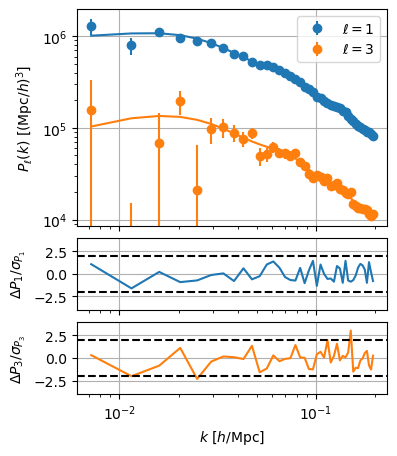

In [8]:
profiler_gv = MinuitProfiler(likelihood_gv, seed=42)
profiles_gv = profiler_gv.maximize(niterations=5)

print(profiles_gv.to_stats(tablefmt='pretty'))

observable_gv(**profiles_gv.bestfit.choice(input=True))
_ = observable_gv.plot(scaling='loglog', kpower=1, figsize=(4, 5))

## Combine

In [29]:
# For now: data_gv and data are not correlated ... 
# Use the mean instead of data:

observable = TracerPowerSpectrumMultipolesObservable(data=mean, covariance=mocks,
                                                     klim={0: [0.005, 0.2, 0.005], 2: [0.005, 0.2, 0.005]}, 
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])
likelihood()

theory_gv.init.params['sigmau'].update(fixed=True, value=0)  # Very weird degeneracy when sampling... --> fix it to speed up the "convergence" 

observable_gv = TracerPowerSpectrumMultipolesObservable(data=mean_gv, covariance=mocks_gv,
                                                        klim={1: [0.005, 0.2, 0.005], 3: [0.005, 0.2, 0.005]},
                                                        theory=theory_gv)
likelihood_gv = ObservablesGaussianLikelihood(observables=[observable_gv])
likelihood_gv()

likelihood_tot = likelihood + likelihood_gv 
likelihood_tot()

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:675: UserWarning: Unable to match step 0.005 with edges [0.     0.0015 0.003  ... 0.297  0.2985 0.3   ]
  warnings.warn('Unable to match step {} with edges {}'.format(xlim[2], self.edges[iaxis]))


[001271.14] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations.
[001271.14] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9129.
[001271.15] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations, varying 4 parameters.
[001271.15] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0841.
[001275.14] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations.
[001275.14] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9129.
[001275.14] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations, varying 4 parameters.
[001275.14] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO 

/global/u2/e/edmondc/Software/desilike/desilike/base.py:450: UserWarning: Parameter fnl_loc of <desilike.theories.galaxy_clustering.primordial_non_gaussianity.PNGTracerPowerSpectrumMultipoles object at 0x7f18bc189d80> is different from that of <desilike.theories.galaxy_clustering.primordial_non_gaussianity.PNGTracerVelocityPowerSpectrumMultipoles object at 0x7f187c2bf8e0>: {'value': (None, 0.0)}.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/global/u2/e/edmondc/Software/desilike/desilike/base.py:445: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f18447c31f0> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f17bc266e60>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/global/u2/e/edmondc/Software/desilike/desilike/base.py:445: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f18447c31f0> is already derived 

Array(-18.88805858, dtype=float64)

In [30]:
profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize(niterations=5)
print(profiles.to_stats(tablefmt='pretty'))

profiler_gv = MinuitProfiler(likelihood_gv, seed=42)
profiles_gv = profiler_gv.maximize(niterations=5)
print(profiles_gv.to_stats(tablefmt='pretty'))

profiler_tot = MinuitProfiler(likelihood_tot, seed=42)
profiles_tot = profiler_tot.maximize(niterations=5)
print(profiles_tot.to_stats(tablefmt='pretty'))

[001275.28] [0/1] 05-05 14:27  MinuitProfiler            INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].
[001275.29] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations, varying 4 parameters.
[001275.29] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0841.
[001275.75] [0/1] 05-05 14:27  MinuitProfiler            INFO     Successfully jit input likelihood.
+------------------------------------+--------+---------+-------+
| chi2 / (86 - 4) = 0.00 / 82 = 0.00 | varied | bestfit | error |
+------------------------------------+--------+---------+-------+
|              fnl_loc               |  True  |   101   |  53   |
|                 b1                 |  True  |  2.000  | 0.029 |
|                sn0                 |  True  |  0.000  | 0.012 |
|               sigmas               |  True  |   0.1   |  9.4  |
+------------------------------------+---

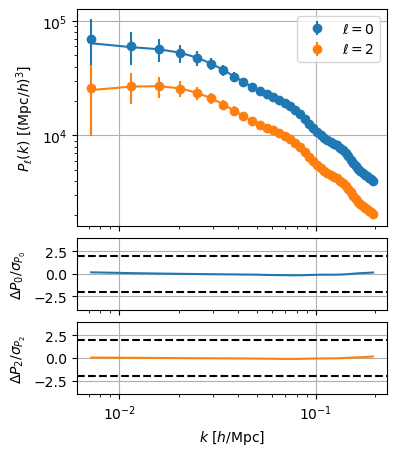

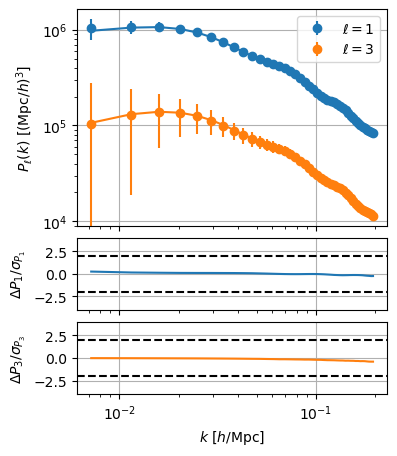

In [31]:
observable(**profiles_tot.bestfit.choice(params=['fnl_loc', 'b1', 'sigmas', 'sn0']))
_ = observable.plot(scaling='loglog', kpower=0, figsize=(4, 5))

observable_gv(**profiles_tot.bestfit.choice(params=['fnl_loc', 'b1', 'bv']))
_ = observable_gv.plot(scaling='loglog', kpower=1, figsize=(4, 5))

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [32]:
from desilike.samplers import EmceeSampler

sampler_tot = EmceeSampler(likelihood_tot, seed=42)
sampler_tot.run(max_iterations=2000)

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(max_iterations=2000)

sampler_gv = EmceeSampler(likelihood_gv, seed=42)
sampler_gv.run(max_iterations=2000)


[001300.73] [0/1] 05-05 14:27  EmceeSampler              INFO     Varied parameters: ['fnl_loc', 'b1', 'bv', 'sigmas', 'sn0'].
[001300.73] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations, varying 4 parameters.
[001300.73] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0841.
[001300.73] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     Covariance matrix with 86 points built from 1000 observations, varying 4 parameters.
[001300.73] [0/1] 05-05 14:27  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0841.
[001301.00] [0/1] 05-05 14:27  EmceeSampler              INFO     Successfully vmap input likelihood.
[001301.06] [0/1] 05-05 14:27  EmceeSampler              INFO     Could *not* jit input likelihood.
[001585.01] [0/1] 05-05 14:32  EmceeSampler              INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].


[Chain(shape=(2000, 10), params=ParameterCollection(['fnl_loc', 'b1', 'bv', 'sigmas', 'logposterior', 'p', 'sigmau', 'loglikelihood', 'logprior']))]

In [36]:
chain = sampler.chains[0].remove_burnin(0.3)[::5]
print(chain.to_stats(tablefmt='pretty'))

chain_gv = sampler_gv.chains[0].remove_burnin(0.3)[::5]
print(chain_gv.to_stats(tablefmt='pretty'))

chain_tot = sampler_tot.chains[0].remove_burnin(0.3)[::5]
print(chain_tot.to_stats(tablefmt='pretty'))

+---------+--------+--------+--------+-------+-----------------+-----------------+
|         | argmax |  mean  | median |  std  | quantile:1sigma | interval:1sigma |
+---------+--------+--------+--------+-------+-----------------+-----------------+
| fnl_loc |   87   |   87   |   87   |  52   |     -53/+53     |     -49/+54     |
|   b1    | 2.008  | 2.012  | 2.011  | 0.028 |  -0.028/+0.028  |  -0.029/+0.025  |
|   sn0   | -0.001 | -0.003 | -0.002 | 0.012 |  -0.012/+0.012  |  -0.013/+0.012  |
| sigmas  |  0.22  |  0.34  |  0.32  | 0.21  |   -0.23/+0.22   |   -0.30/+0.13   |
+---------+--------+--------+--------+-------+-----------------+-----------------+
+---------+--------+-------+--------+-------+-----------------+-----------------+
|         | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+---------+--------+-------+--------+-------+-----------------+-----------------+
| fnl_loc |  110.  |  97   |   96   |  52   |     -53/+54     |     -61/+44     |
|   b1  

Removed no burn in
Removed no burn in
Removed no burn in


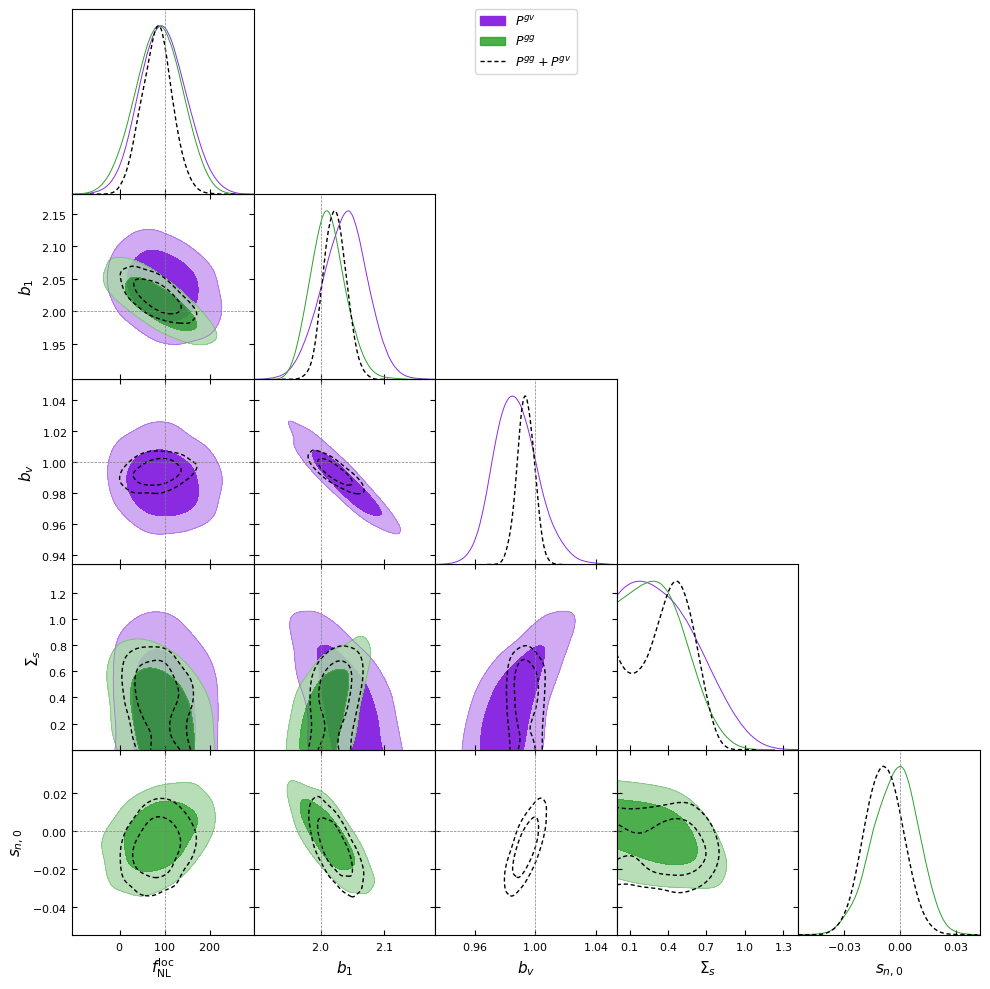

In [45]:
from desilike.samples import plotting  # you may need to activate: %matplotlib inline
_ = plotting.plot_triangle([chain_gv, chain, chain_tot], 
                           ['fnl_loc', 'b1', 'bv', 'sigmas', 'sn0'], 
                           labels=['$P^{gv}$', '$P^{gg}$', '$P^{gg} + P^{gv}$'],
                           markers={'fnl_loc': 100., 'b1': b1, 'bv':1, 'sn0': 0., 'sigmas': 0.}, 
                           contour_colors=['blueviolet', '#2ca02c', 'k'],  #'#ff7f0e', '#d62728', 
                           filled=[True, True, False],
                           contour_ls=['-', '-', '--'], 
                           contour_lws=[0.7, 0.7, 1.0],
                           )